## Dataset Info.

- train.parquet
    - 총 10,704,179개 샘플
    - 총 119개 ('clicked' Target 컬럼 포함) 컬럼 존재
        - gender : 성별
        - age_group : 연령 그룹
        - inventory_id : 지면 ID
        - day_of_week : 주번호
        - hour : 시간
        - seq : 유저 서버 로그 시퀀스
        - l_feat_* : 속성 정보 피처 (l_feat_14는 Ads set)
        - feat_e_* : 정보영역 e 피처
        - feat_d_* : 정보영역 d 피처
        - feat_c_* : 정보영역 c 피처
        - feat_b_* : 정보영역 b 피처
        - feat_a_* : 정보영역 a 피처
        - history_a_* : 과거 인기도 피처
        - clicked : 클릭 여부 (Label)


- test.parquet 
    - 총 1,527,298개 샘플
    - 총 118개 ('ID' 식별자 컬럼 포함) 컬럼 존재
        - ID : 샘플 식별자
        - gender : 성별
        - age_group : 연령 그룹
        - inventory_id : 지면 ID
        - day_of_week : 주번호
        - hour : 시간
        - seq : 유저 서버 로그 시퀀스
        - l_feat_* : 속성 정보 피처 (l_feat_14는 Ads set)
        - feat_e_* : 정보영역 e 피처
        - feat_d_* : 정보영역 d 피처
        - feat_c_* : 정보영역 c 피처
        - feat_b_* : 정보영역 b 피처
        - feat_a_* : 정보영역 a 피처
        - history_a_* : 과거 인기도 피처


- sample_submission.csv [파일] - 제출 양식
- ID : 샘플 식별자
- clicked : 광고를 클릭할 확률 (0 ~ 1)


In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

---

In [2]:
# 데이터 로드
all_train = pd.read_parquet("./train.parquet", engine="pyarrow")
test = pd.read_parquet("./test.parquet", engine="pyarrow")

print("Train shape:", all_train.shape)
print("Test shape:", test.shape)

Train shape: (10704179, 119)
Test shape: (1527298, 119)


In [3]:
all_train.head(10)

,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
0,1.0,7.0,36,5,13,"9,18,269,516,57,97,527,74,317,311,269,479,57,7...",1.0,2.0,1.0,23.0,...,0.070092,0.070092,0.011682,0.004673,0.087226,0.049843,0.015576,0.040498,0.051401,0
1,1.0,7.0,2,5,08,"9,144,269,57,516,97,527,74,315,317,311,269,479...",2.0,2.0,3.0,17.0,...,0.072990,0.072990,0.012165,0.004866,0.045416,0.051904,0.016220,0.042172,0.026763,0
2,1.0,7.0,36,5,11,"269,516,57,97,165,527,74,77,317,269,75,450,15,...",1.0,2.0,1.0,7.0,...,0.057177,0.057177,0.009530,0.003812,0.035577,0.081318,0.012706,0.033036,0.062898,0
3,1.0,8.0,37,5,11,"269,57,516,21,214,269,561,214,269,561,247,516,...",2.0,2.0,2.0,7.0,...,0.100449,0.100449,0.016741,0.006697,0.062502,0.071430,0.022322,0.058037,0.073659,0
4,2.0,7.0,37,5,07,"144,269,57,516,35,479,57,516,527,74,77,318,193...",2.0,2.0,3.0,24.0,...,0.064512,0.064512,0.010752,0.004301,0.040141,0.045875,0.014336,0.037274,0.023654,0
5,1.0,5.0,2,5,08,"9,516,57,527,74,77,532,101,132,138,101,101,132...",2.0,2.0,3.0,17.0,...,0.049338,0.049338,0.008223,0.003289,0.030699,0.035085,0.021930,0.028506,0.036185,0
6,1.0,7.0,43,5,10,"9,516,57,221,97,63,520,426,221,426,97,516,227,...",2.0,1.0,2.0,8.0,...,0.079362,0.079362,0.013227,0.005291,0.049381,0.056435,0.035274,0.045854,0.058202,0
7,1.0,6.0,36,5,10,"57,516,338,416,74,527,77,318,452,207,51,452,47...",1.0,2.0,1.0,6.0,...,0.318024,0.318024,0.053004,0.021202,0.395758,0.226150,0.070672,0.183747,0.233214,0
8,1.0,7.0,37,5,01,"57,516,97,165,74,527,317,269,311,479,57,74,21,...",2.0,2.0,3.0,14.0,...,0.151263,0.151263,0.025210,0.010084,0.094119,0.107565,0.033614,0.087396,0.055463,0
9,1.0,6.0,42,5,22,"9,269,57,516,74,207,452,452,245,269,508,51,74,...",2.0,2.0,2.0,7.0,...,0.065025,0.065025,0.010837,0.004335,0.040460,0.046240,0.014450,0.037570,0.023843,0


In [4]:
test.tail(10)

,ID,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,...,history_b_21,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30
1527288,TEST_1527288,1.0,6.0,37,7,13,"9,57,516,97,195,27,516,97,195,27,516,527,74,77...",2.0,2.0,2.0,...,0.005949,0.048672,0.048672,0.008112,0.003245,0.060575,0.034611,0.021634,0.056248,0.178474
1527289,TEST_1527289,2.0,3.0,88,7,18,"144,57,516,27,516,479,57,281,130,455,281,64,47...",2.0,2.0,3.0,...,0.052885,0.432693,0.432693,0.072116,0.028846,0.269231,0.307693,0.096154,0.250000,0.158654
1527290,TEST_1527290,1.0,7.0,36,7,08,"9,269,516,527,74,77,207,452,51,452,269,508,508...",1.0,2.0,1.0,...,0.010618,0.086877,0.086877,0.014480,0.005792,0.054057,0.061779,0.019306,0.050196,0.063707
1527291,TEST_1527291,1.0,7.0,37,7,16,"144,9,18,269,57,516,527,97,74,77,318,452,207,2...",2.0,2.0,3.0,...,0.004542,0.037161,0.037161,0.006194,0.002477,0.023122,0.026426,0.008258,0.021471,0.081751
1527292,TEST_1527292,1.0,8.0,42,7,08,"144,9,269,57,516,97,516,97,74,527,318,77,317,1...",2.0,2.0,3.0,...,0.012075,0.098793,0.098793,0.016465,0.006586,0.061471,0.070253,0.021954,0.057080,0.108672
1527293,TEST_1527293,1.0,7.0,42,7,10,"9,57,516,195,27,516,27,516,527,74,318,77,207,4...",2.0,2.0,3.0,...,0.004558,0.037296,0.037296,0.006216,0.002486,0.023206,0.026522,0.008288,0.021549,0.027350
1527294,TEST_1527294,1.0,8.0,39,7,13,"9,516,57,97,74,527,77,318,193,463,212,151,331,...",2.0,2.0,2.0,...,0.029810,0.243900,0.243900,0.040650,0.016260,0.151760,0.173440,0.054200,0.140920,0.089430
1527295,TEST_1527295,2.0,7.0,2,7,13,"144,9,57,516,484,97,309,484,516,74,527,77,318,...",2.0,2.0,3.0,...,0.002378,0.019458,0.019458,0.003243,0.001297,0.024214,0.013837,0.004324,0.011242,0.057080
1527296,TEST_1527296,2.0,4.0,2,7,00,"57,516,97,479,57,516,106,97,479,516,57,106,106...",2.0,1.0,3.0,...,0.104762,0.857142,0.857142,0.142857,0.057143,0.533333,0.609523,0.190476,0.495238,0.314285
1527297,TEST_1527297,1.0,6.0,41,7,07,"269,516,57,527,74,77,318,207,452,452,508,51,26...",2.0,2.0,3.0,...,0.011111,0.090909,0.090909,0.015151,0.006061,0.056566,0.064646,0.020202,0.052525,0.100000


In [5]:
# clicked == 1 데이터
clicked_1 = all_train[all_train['clicked'] == 1]

# clicked == 0 데이터에서 동일 개수x2 만큼 무작위 추출 (다운 샘플링)
clicked_0 = all_train[all_train['clicked'] == 0].sample(n=int(len(clicked_1)*2), random_state=111)

# 두 데이터프레임 합치기
train = pd.concat([clicked_1, clicked_0], axis=0).sample(frac=1, random_state=111).reset_index(drop=True)

In [6]:
train.head(10)

,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
0,2.0,7.0,2,3,19,"57,97,221,63,520,426,516,189,426,97,221,426,18...",2.0,2.0,3.0,7.0,...,0.769230,0.769230,0.128205,0.051282,0.478632,0.547008,0.170940,0.444444,0.282051,1
1,2.0,4.0,31,6,18,"35,516,57,165,71,68,528,479,57,516,71,165,338,...",2.0,1.0,3.0,6.0,...,1.111113,1.111113,0.185186,0.074074,0.691359,0.790125,0.246914,0.641976,0.407408,0
2,2.0,7.0,2,2,14,"516,57,527,74,318,463,193,212,151,331,269,470,...",2.0,2.0,3.0,7.0,...,0.511362,0.511362,0.085227,0.034091,0.318181,0.363635,0.113636,0.295454,0.374999,1
3,2.0,6.0,43,3,13,"144,9,269,57,516,97,74,527,77,207,452,269,452,...",2.0,1.0,3.0,20.0,...,0.089460,0.089460,0.014910,0.005964,0.055664,0.063616,0.039762,0.051688,0.131211,0
4,1.0,3.0,42,6,23,"9,57,469,479,57,479,316,57,74,77,318,532,132,1...",2.0,2.0,2.0,16.0,...,0.039627,0.039627,0.006605,0.002642,0.024657,0.028179,0.008806,0.022896,0.029063,0
5,1.0,8.0,2,6,16,"9,269,516,57,227,417,121,27,27,121,227,527,74,...",2.0,2.0,2.0,7.0,...,0.050823,0.050823,0.008470,0.003388,0.031623,0.036141,0.011294,0.029364,0.093169,0
6,2.0,5.0,42,4,07,"9,57,516,338,416,114,516,551,457,302,156,203,1...",2.0,2.0,2.0,7.0,...,0.094734,0.094734,0.015789,0.006316,0.058946,0.067366,0.021052,0.054735,0.034736,1
7,2.0,7.0,37,7,00,"321,9,57,74,77,318,212,463,193,151,331,269,470...",2.0,2.0,2.0,6.0,...,0.028971,0.028971,0.004829,0.001931,0.018026,0.020602,0.006438,0.016739,0.010623,0
8,2.0,6.0,46,1,00,"9,436,57,114,516,527,193,74,77,463,463,212,151...",2.0,2.0,3.0,19.0,...,0.084510,0.084510,0.014085,0.005634,0.105162,0.060096,0.018780,0.048828,0.092958,0
9,1.0,1.0,29,6,21,"57,516,516,195,27,516,395,324,97,516,479,516,5...",2.0,2.0,3.0,11.0,...,22.500000,22.500000,3.750000,1.500000,14.000000,16.000000,5.000000,13.000000,8.250000,1


In [7]:
del all_train

In [8]:
train.to_parquet('./train_ds_ratio2.parquet', engine='pyarrow')

---

In [3]:
# under sampling dataset
train = pd.read_parquet('./train_ds_ratio2.parquet', engine='pyarrow')

In [4]:
train.tail()

,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
612532,2.0,6.0,11,6,03,"9,57,27,27,516,527,74,77,318,516,114,457,173,4...",2.0,2.0,3.0,7.0,...,0.043857,0.043857,0.007310,0.002924,0.027289,0.031187,0.009746,0.025340,0.016081,0
612533,1.0,6.0,36,4,06,"57,516,527,74,77,318,193,463,212,151,331,151,2...",1.0,1.0,1.0,14.0,...,0.428571,0.428571,0.071429,0.028571,0.266666,0.304762,0.095238,0.247619,0.157143,1
612534,1.0,7.0,2,6,08,"9,144,57,516,165,227,417,132,532,101,138,479,5...",2.0,2.0,3.0,20.0,...,0.094941,0.094941,0.015824,0.006329,0.059074,0.067514,0.021098,0.054855,0.034812,1
612535,1.0,8.0,2,5,22,"144,57,516,165,74,527,77,318,317,469,479,35,26...",2.0,2.0,2.0,16.0,...,0.028629,0.028629,0.004771,0.001909,0.017814,0.040710,0.006362,0.016541,0.104963,0
612536,1.0,8.0,19,7,08,"9,269,516,57,97,195,27,27,516,97,195,27,516,97...",2.0,2.0,2.0,7.0,...,0.049131,0.049131,0.008189,0.003275,0.030570,0.034938,0.010918,0.028387,0.108078,0


In [5]:
train['clicked'].value_counts(normalize=True)

clicked
0    0.666667
1    0.333333
Name: proportion, dtype: float64

In [6]:
all_columns = train.columns.tolist()

# setting data types (categorical / numerical)
# Target
target_col = "clicked"

# Categorical Features
categorical_features = [
    "gender",
    "age_group",
    "inventory_id",
    "day_of_week",
    "hour"
]

# Numeric Features
numeric_features = [
    col for col in all_columns
    if col not in categorical_features and col != target_col and col not in ('l_feat_14','seq')
]

print("Target:", target_col)
print("Categorical Features:", categorical_features)
print("Numeric Features (count={}):".format(len(numeric_features)), numeric_features[:10], "...")

# df 의 dtype 을 맞추기
# train[categorical_features] = train[categorical_features].astype("category")
# train[numeric_features] = train[numeric_features].astype(float)

Target: clicked
Categorical Features: ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour']
Numeric Features (count=111): ['l_feat_1', 'l_feat_2', 'l_feat_3', 'l_feat_4', 'l_feat_5', 'l_feat_6', 'l_feat_7', 'l_feat_8', 'l_feat_9', 'l_feat_10'] ...


In [7]:
# feature extraction for l_feat_14, seq
# from sklearn.model_selection import KFold

def frequency_encoding(df: pd.DataFrame, col: str) -> pd.Series:
    """
    주어진 카테고리 변수 col을 빈도 인코딩하여 numeric feature 반환
    """
    freq_map = df[col].value_counts().to_dict()
    return df[col].map(freq_map)

def target_encoding(df: pd.DataFrame, col: str, target: str) -> pd.Series:
    """
    col: 인코딩할 카테고리 변수
    target: 라벨 변수
    """
    df[col] = df[col].astype(str)
    stats = df.groupby(col)[target].mean().to_dict()
    
    # unseen category 처리 (global mean 대체)
    global_mean = df[target].mean()
    df_encoded = df[col].map(stats).fillna(global_mean)

    return df_encoded

def frequency_encoding_train(df, col):
    freq_map = df[col].value_counts().to_dict()
    global_mean = df[col].value_counts().mean()
    return freq_map, global_mean

def frequency_encoding_apply(df, col, freq_map, global_mean):
    return df[col].map(freq_map).fillna(global_mean)

def target_encoding_train(df, col, target):
    mean_map = df.groupby(col)[target].mean().to_dict()
    global_mean = df[target].mean()
    return mean_map, global_mean

def target_encoding_apply(df, col, mean_map, global_mean):
    return df[col].map(mean_map).fillna(global_mean)

def feature_engineering(df: pd.DataFrame, categorical_features:list, numeric_features:list, test_yn = False) -> pd.DataFrame:
    history_a_cols = [c for c in train.columns if 'history_a' in c and 'avg' not in c]
    history_b_cols = [c for c in train.columns if 'history_b' in c and 'avg' not in c]
    
    if test_yn:
        # Train 기준 encoding map 생성
        freq_map, freq_global = frequency_encoding_train(train, "l_feat_14")
        te_map, te_global = target_encoding_train(train, "l_feat_14", "clicked")
        te_map_iv, te_global_iv = target_encoding_train(train, "inventory_id", "clicked")
        
        # Test 변환 (같은 맵 사용)
        df["l_feat_14_freq"] = frequency_encoding_apply(df, "l_feat_14", freq_map, freq_global)
        df["l_feat_14_te"] = target_encoding_apply(df, "l_feat_14", te_map, te_global)
        df["inventory_te"] = target_encoding_apply(df, "inventory_id", te_map, te_global)

        df['seq_length'] = df['seq'].apply(lambda x:len(x.split(',')))
        df['seq_first'] = (df['seq'].apply(lambda x:x.split(',')[0])).astype('category')
        df['seq_last'] = (df['seq'].apply(lambda x:x.split(',')[-1])).astype('category')
        df['seq_nunique'] = df['seq'].apply(lambda x:len(set(x.split(','))))
        
        df['history_a_score_avg'] = df[history_a_cols].mean(axis=1)
        df['history_b_score_avg'] = df[history_b_cols].mean(axis=1)
        
        test_prep = df.loc[:, categorical_features+numeric_features]
        return test_prep
    else:
        df["l_feat_14_freq"] = frequency_encoding(df, "l_feat_14")
        df["l_feat_14_te"] = target_encoding(df, "l_feat_14", target="clicked")
        df["inventory_te"] = target_encoding(df, "inventory_id", target="clicked")
        
        df['seq_length'] = df['seq'].apply(lambda x:len(x.split(',')))
        df['seq_first'] = (df['seq'].apply(lambda x:x.split(',')[0])).astype('category')
        df['seq_last'] = (df['seq'].apply(lambda x:x.split(',')[-1])).astype('category')
        df['seq_nunique'] = df['seq'].apply(lambda x:len(set(x.split(','))))

        df['history_a_score_avg'] = df[history_a_cols].mean(axis=1)
        df['history_b_score_avg'] = df[history_b_cols].mean(axis=1)
        
        categorical_features += ['seq_first','seq_last']
        numeric_features += ['l_feat_14_freq','l_feat_14_te','seq_length','seq_nunique', 'history_a_score_avg', 'history_b_score_avg','inventory_te']   

        train_prep = df.loc[:, categorical_features+numeric_features+[target_col]].copy()

        return train_prep

In [8]:
train_prep = feature_engineering(train, categorical_features, numeric_features, False)

In [9]:
for col in categorical_features:
    train_prep[col] = train_prep[col].astype("category")

for col in numeric_features:
    train_prep[col] = train_prep[col].astype(float)
train_prep.shape

(612537, 126)

In [10]:
train_prep[target_col].value_counts(normalize=True)

clicked
0    0.666667
1    0.333333
Name: proportion, dtype: float64

In [11]:
# split validation set
train_df, valid_df = train_test_split(train_prep, test_size=0.2, random_state=42, stratify=train[target_col])

X_train, y_train = train_df.drop(columns=[target_col]), train_df[target_col]
X_valid, y_valid = valid_df.drop(columns=[target_col]), valid_df[target_col]

In [12]:
train_df.shape

(490029, 126)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 490029 entries, 271720 to 389067
Columns: 126 entries, gender to clicked
dtypes: category(7), float64(118), int32(1)
memory usage: 451.0 MB


In [20]:
lgbm_model = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=2,
    )

In [21]:
from sklearn.metrics import roc_auc_score, log_loss,accuracy_score
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 163343, number of negative: 326686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19305
[LightGBM] [Info] Number of data points in the train set: 490029, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
               random_state=42, scale_pos_weight=2, subsample=0.9)

In [22]:
y_pred_proba = lgbm_model.predict_proba(X_valid)[:, 1]
print("Validation AUC:", roc_auc_score(y_valid, y_pred_proba))
print("Validation LogLoss:", log_loss(y_valid, y_pred_proba))

Validation AUC: 0.7433821754841877
Validation LogLoss: 0.5930343007520773


In [23]:
y_pred = lgbm_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Test set accuracy: {:.2f}".format(accuracy))
pd.DataFrame(classification_report(y_valid, y_pred, output_dict= True)).T

Test set accuracy: 0.69


,precision,recall,f1-score,support
0,0.801874,0.702199,0.748734,81672.0000
1,0.522986,0.653002,0.580807,40836.0000
accuracy,0.685800,0.685800,0.685800,0.6858
macro avg,0.662430,0.677601,0.664770,122508.0000
weighted avg,0.708911,0.685800,0.692758,122508.0000


In [24]:
test_df = pd.read_parquet("./test.parquet", engine="pyarrow")
test_ids = test_df["ID"]

In [25]:
X_test = feature_engineering(test_df, categorical_features, numeric_features, test_yn = True)

In [26]:
len(categorical_features) + len(numeric_features)

125

In [27]:
for col in categorical_features:
    X_test[col] = X_test[col].astype("category")

for col in numeric_features:
    X_test[col] = X_test[col].astype(float)

In [28]:
X_test.shape

(1527298, 125)

In [29]:
y_test_proba = lgbm_model.predict_proba(X_test)[:, 1] 

In [30]:
submit = pd.read_csv('./sample_submission.csv')
submit['clicked'] = y_test_proba

In [31]:
submit.to_csv('./baseline_lgbm_submit_ratio2.csv', index=False)

In [33]:
from xgboost.sklearn import XGBClassifier
xgb_model =  XGBClassifier(**{'n_estimators':100, 
                               'booster':'gbtree',
                               'max_depth': 15,
                               'learning_rate':0.05,
                               'scale_pos_weight':2,
                               'subsample':0.9
                              }
                            , enable_categorical=True
                            , random_state= 123)
xgb_model.fit(X_train,y_train)
y_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
print("Validation AUC:", roc_auc_score(y_valid, y_pred_proba))
print("Validation LogLoss:", log_loss(y_valid, y_pred_proba))

y_pred = xgb_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Test set accuracy: {:.2f}".format(accuracy))
pd.DataFrame(classification_report(y_valid, y_pred, output_dict= True)).T

Validation AUC: 0.7354796576293443
Validation LogLoss: 0.5758626196690405
Test set accuracy: 0.70


,precision,recall,f1-score,support
0,0.780214,0.769811,0.774978,81672.00000
1,0.551580,0.566290,0.558838,40836.00000
accuracy,0.701970,0.701970,0.701970,0.70197
macro avg,0.665897,0.668050,0.666908,122508.00000
weighted avg,0.704003,0.701970,0.702931,122508.00000


In [34]:
y_test_proba = xgb_model.predict_proba(X_test)[:, 1] 
submit = pd.read_csv('./sample_submission.csv')
submit['clicked'] = y_test_proba
submit.to_csv('./baseline_xgb_submit_ratio2.csv', index=False)

---

In [22]:
X_valid.shape

(122508, 121)

In [26]:
import shap
explainer = shap.TreeExplainer(lgbm_model)
# Calculate Shap values
shap_values = explainer.shap_values(X_valid)

/opt/conda/envs/xgboost/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


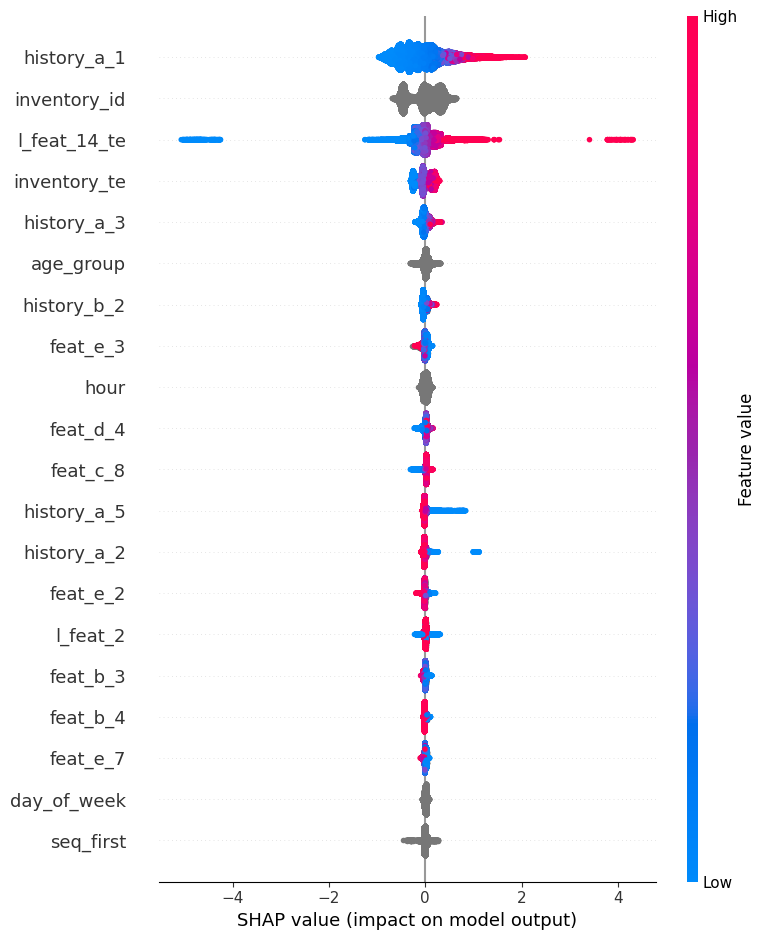

In [27]:
shap.summary_plot(shap_values, X_valid)